In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']
Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


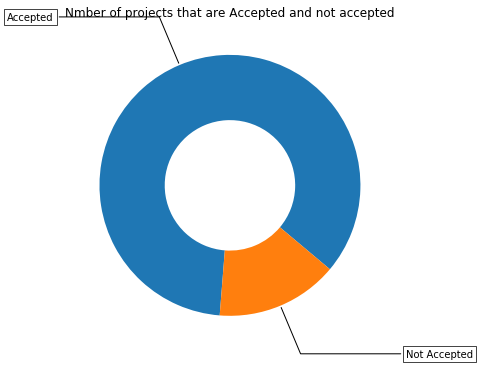

In [3]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

In [4]:
# Pandas dataframe grouby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

In [5]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


In [6]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [7]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

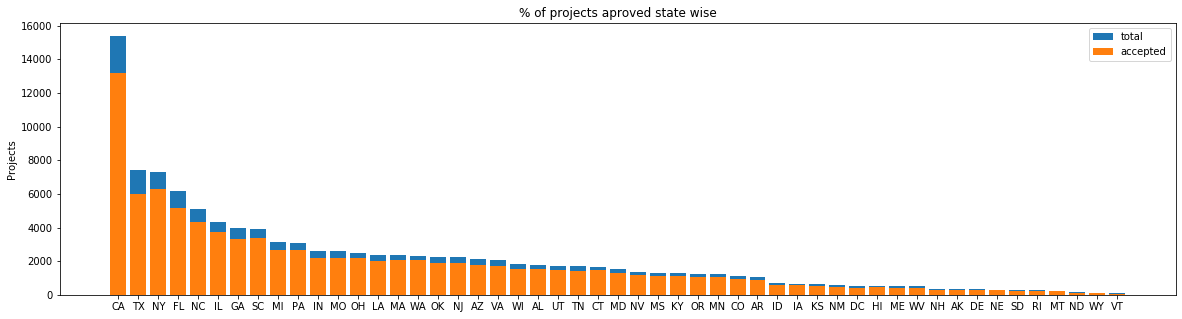

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [8]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

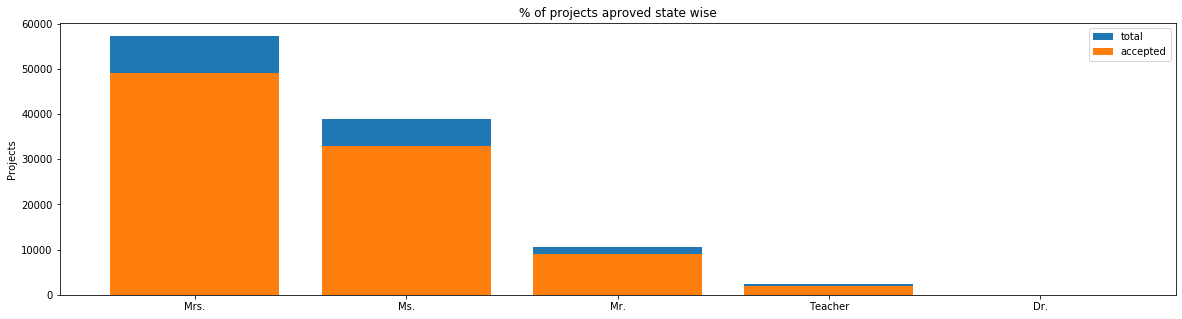

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [9]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

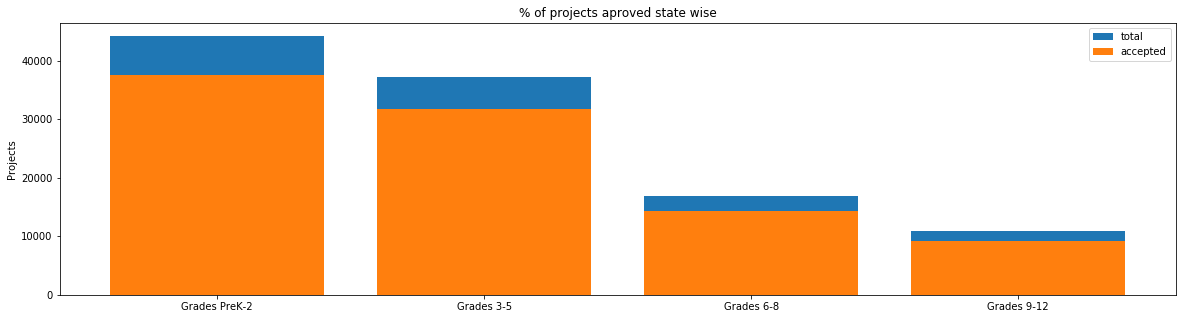

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [10]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

In [11]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [12]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

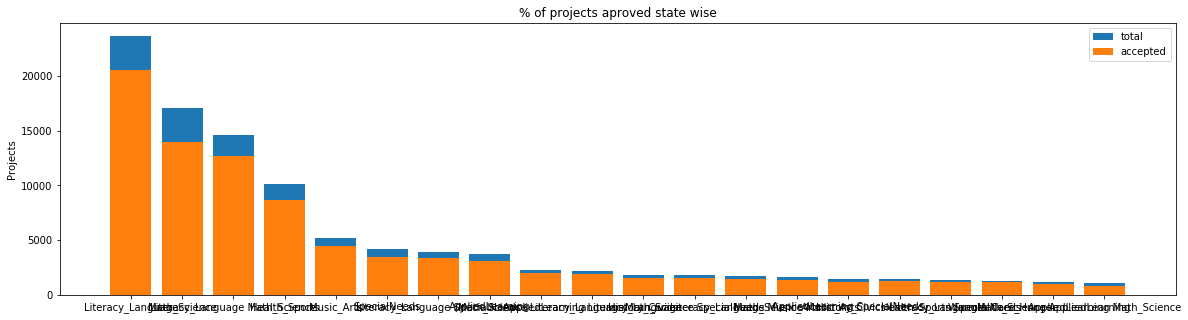

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [13]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

In [14]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

In [15]:
my_counter

Counter({'Literacy_Language': 52239,
         'History_Civics': 5914,
         'Health_Sports': 14223,
         'Math_Science': 41421,
         'SpecialNeeds': 13642,
         'AppliedLearning': 12135,
         'Music_Arts': 10293,
         'Warmth': 1388,
         'Care_Hunger': 1388})

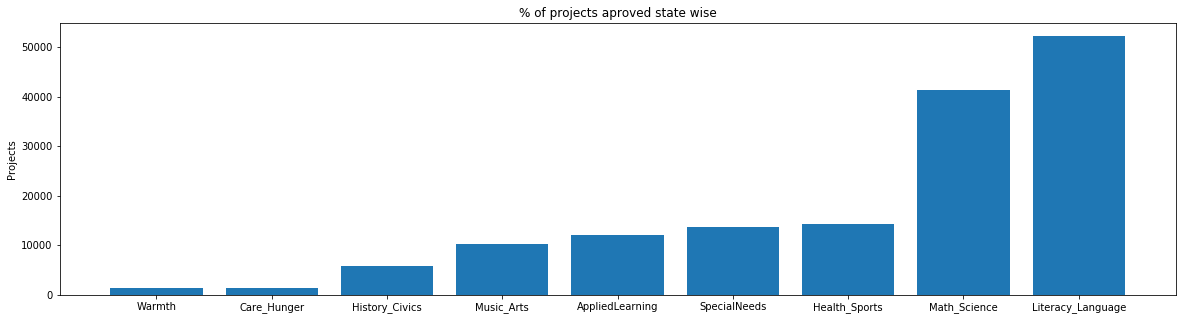

In [16]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))
plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [17]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


In [18]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
sub_cat_list = [] #preprocessing sub_categories
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [19]:
project_data['clean_subcategories'] = sub_cat_list 
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

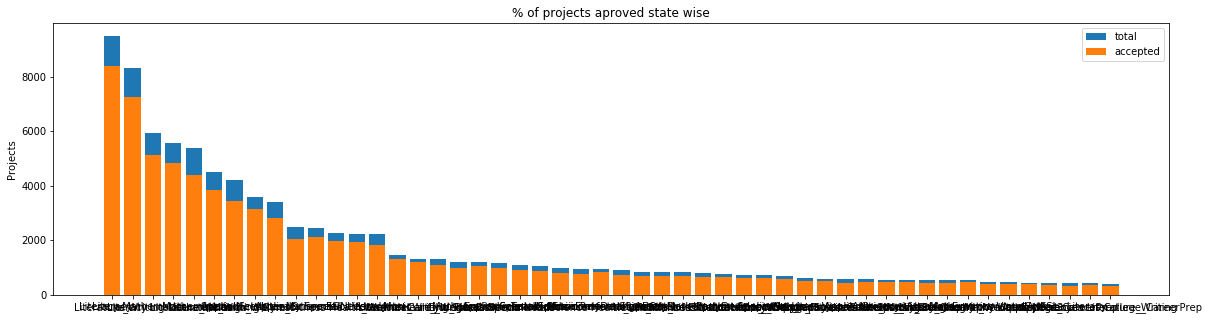

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [20]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [21]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

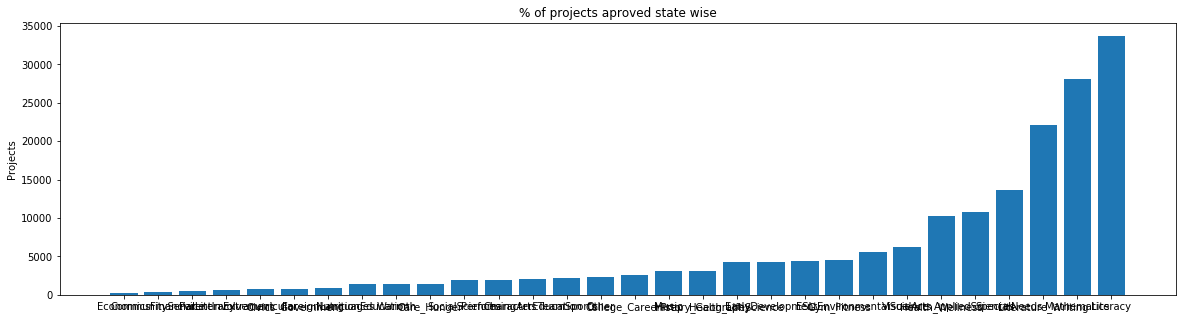

In [22]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [23]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


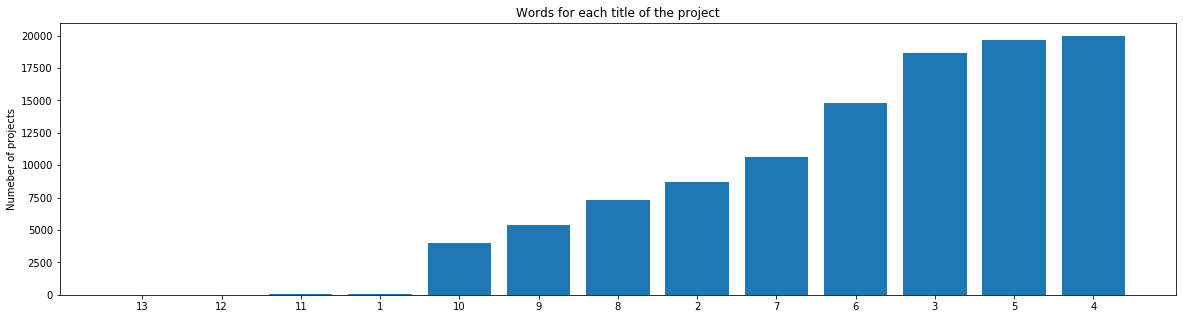

In [24]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

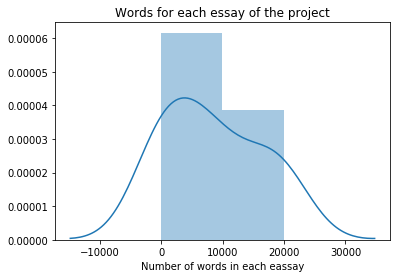

In [25]:
sns.distplot(word_count.values)
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.show()

In [26]:
approved_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_word_count = approved_word_count.values
rejected_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

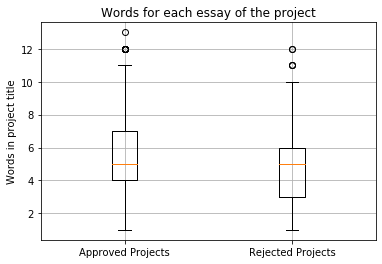

In [27]:
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

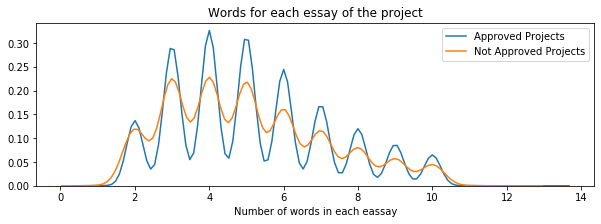

In [28]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

In [29]:
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [30]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [31]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [32]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values
rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

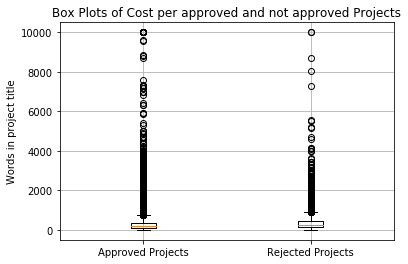

In [33]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

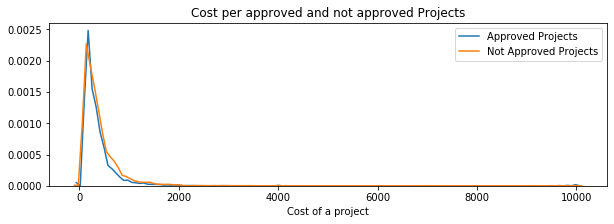

In [34]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [35]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

In [36]:
#1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects
project_data[project_data['teacher_number_of_previously_posted_projects']==project_data['teacher_number_of_previously_posted_projects'].max()]
# row of max value of teacher_number_of_previously_posted_projects row

Unnamed: 0       id                        teacher_id teacher_prefix  \
88015      109994  p043212  fa2f220b537e8653fb48878ebb38044d           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
88015           PA        2017-04-27 21:30:17          Grades PreK-2   

             project_title                                    project_essay_1  \
88015  Food to Bring Home!  I currently have 25 six- and seven-year-old st...   

                                         project_essay_2 project_essay_3  \
88015  I would love if my students could bring home f...             NaN   

      project_essay_4                           project_resource_summary  \
88015             NaN  My students need Life Essential Healthy foods ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
88015                                           451                    1   

         clean_categories clean_subcategories   price  quantity  
88015  Warmth Care_Hunger  Warmth Care_Hunger  123.71         8

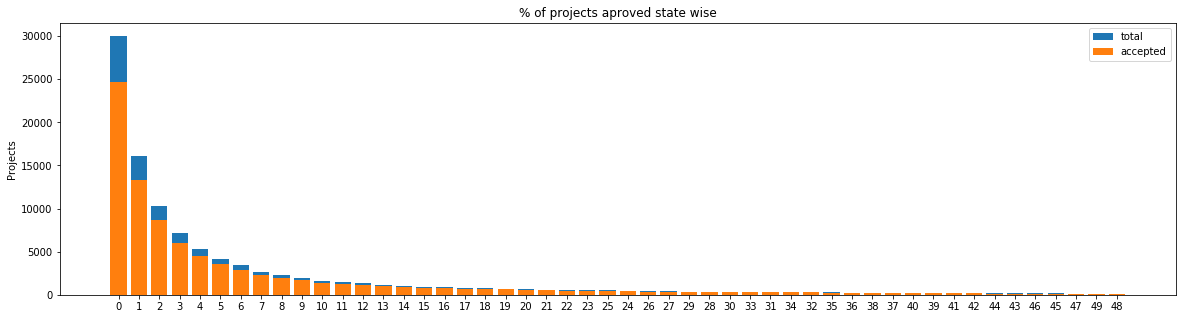

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
46                                            46                  149    164   
45                                            45                  141    153   
47                                            47                  129    144   
49                                            49                  128    143   
48                                       

In [37]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved',50 )

In [38]:
approved_project = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values
rejected_project = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values


Teachers having more previous project proposals have greater chance of project approvals.

In [39]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Percentile", "Approved_Project", "rejected_Project"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_project,i), 3), np.round(np.percentile(rejected_project,i), 3)])
print(x)

+------------+------------------+------------------+
| Percentile | Approved_Project | rejected_Project |
+------------+------------------+------------------+
|     0      |       0.0        |       0.0        |
|     5      |       0.0        |       0.0        |
|     10     |       0.0        |       0.0        |
|     15     |       0.0        |       0.0        |
|     20     |       0.0        |       0.0        |
|     25     |       0.0        |       0.0        |
|     30     |       1.0        |       0.0        |
|     35     |       1.0        |       1.0        |
|     40     |       1.0        |       1.0        |
|     45     |       2.0        |       1.0        |
|     50     |       2.0        |       2.0        |
|     55     |       3.0        |       2.0        |
|     60     |       4.0        |       3.0        |
|     65     |       5.0        |       3.0        |
|     70     |       7.0        |       4.0        |
|     75     |       9.0        |       6.0   

the table shows as the teacher_number_of_previously_posted_projects increases the chance of project approval increases significantly.

In [40]:
import re
digit_in_summary=[]
summary_array=project_data["project_resource_summary"].values
for i in summary_array:
    digit=re.search(r'\d', i)
    if (bool(digit)==False):
        digit_in_summary.append(0)
    else:
        digit_in_summary.append(1)
project_data['digits_in_summary'] = digit_in_summary
project_data['digits_in_summary'].value_counts()#false=0 and true =1 in bool(digit_summary)

0    93492
1    15756
Name: digits_in_summary, dtype: int64

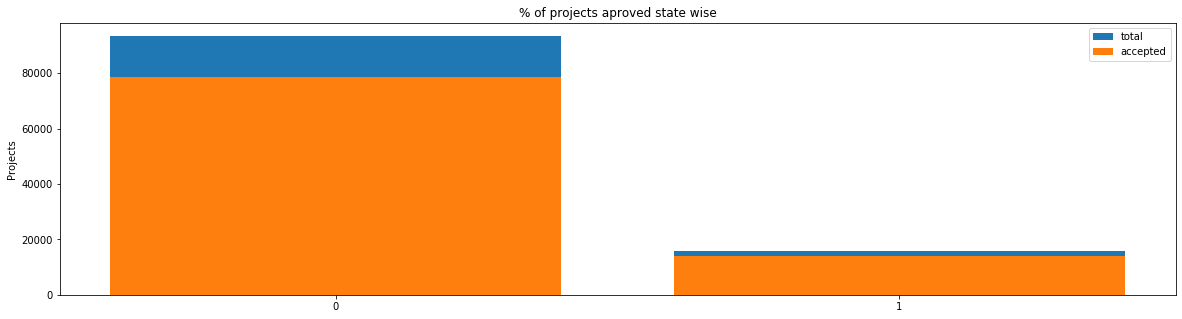

   digits_in_summary  project_is_approved  total       Avg
0                  0                78616  93492  0.840885
1                  1                14090  15756  0.894263
   digits_in_summary  project_is_approved  total       Avg
0                  0                78616  93492  0.840885
1                  1                14090  15756  0.894263


In [41]:
univariate_barplots(project_data, 'digits_in_summary', 'project_is_approved', top=False)


if digit present in project_summary high chance that project is approved 

In [42]:
project_data.head(5)
#reading data
#project_data = pd.read_csv('train_data.csv')
#project_data.shape

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories           clean_subcategories   price  \
0               Literacy_Language                  ESL Literacy  154.60   
1    History_Civics Health_Sports  Civics_Government TeamSports  299.00   
2                   Health_Sports    Health_Wellness TeamSports  516.85   
3  Literacy_Language Math_Science          Literacy Mathematics  232.90   
4                    Math_Science                   Mathematics   67.98   

   quantity  digits_in_summary  
0        23                  0  
1         1                  0  
2        22                  0  
3         4                  0  
4         4                  0

In [43]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)


Number of data points in train data (109248, 20)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category' 'project_title'
 'project_essay_1' 'project_essay_2' 'project_essay_3' 'project_essay_4'
 'project_resource_summary' 'teacher_number_of_previously_posted_projects'
 'project_is_approved' 'clean_categories' 'clean_subcategories' 'price'
 'quantity' 'digits_in_summary']


In [44]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [45]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  price  \
0             Literacy_Language                  ESL Literacy  154.6   
1  History_Civics Health_Sports  Civics_Government TeamSports  299.0   

   quantity  digits_in_summary  
0        23                  0  
1         1                  0

In [46]:
#preprocessing grade category
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

In [47]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [48]:
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


In [49]:
#fill missing values with "Mrs." and convert to lowercase as most have mrs. prefix on them
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

In [50]:
#numebr of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')

In [51]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            mrs   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             mr   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          grades_prek_2   
1           FL        2016-10-25 09:22:10             grades_6_8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  price  \
0             Literacy_Language                  ESL Literacy  154.6   
1  History_Civics Health_Sports  Civics_Government TeamSports  299.0   

   quantity  digits_in_summary  
0        23                  0  
1         1                  0

In [52]:
print(project_data.columns)

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'price', 'quantity',
       'digits_in_summary'],
      dtype='object')


In [53]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

In [54]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [55]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [56]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [57]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [58]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:31<00:00, 1194.18it/s]


In [59]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [60]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [61]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'price_x', 'quantity_x',
       'digits_in_summary', 'essay', 'price_y', 'quantity_y'],
      dtype='object')

In [62]:
#adding count of words in project_resource_summary feature 
word_count=[]
for i in project_data["project_resource_summary"].values:
    c=0
    for k in i.split():
        c+=1
    word_count.append(c)
project_data['word_count'] = word_count

In [63]:
project_data.columns
project_data.drop('Unnamed: 0', axis=1,inplace=True)
project_data.drop('id', axis=1,inplace=True)
project_data.drop('project_resource_summary', axis=1,inplace=True)
project_data.drop('price_y', axis=1,inplace=True)
project_data.drop('quantity_y', axis=1,inplace=True)

project_data.drop('project_essay_2', axis=1,inplace=True)
project_data.drop('project_essay_3', axis=1,inplace=True)
project_data.drop('project_essay_4', axis=1,inplace=True)
project_data.drop('project_essay_1', axis=1,inplace=True)
project_data.drop('project_submitted_datetime', axis=1,inplace=True)
project_data.drop('teacher_id', axis=1,inplace=True)

project_data.head(5)


teacher_prefix school_state project_grade_category  \
0            mrs           in          grades_prek_2   
1             mr           fl             grades_6_8   
2             ms           az             grades_6_8   
3            mrs           ky          grades_prek_2   
4            mrs           tx          grades_prek_2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories           clean_subcategories  price_x  \
0               Literacy_Language                  ESL Literacy   154.60   
1    History_Civics Health_Sports  Civics_Government TeamSports   299.00   
2                   Health_Sports    Health_Wellness TeamSports   516.85   
3  Literacy_Language Math_Science          Literacy Mathematics   232.90   
4                    Math_Science                   Mathematics    67.98   

   quantity_x  digits_in_summary  \
0          23                  0   
1           1                  0   
2          22                  0   
3           4                  0   
4           4                  0   

                                               essay  word_count  
0  My students are English learners that are work...          13  
1  Our students arrive to our school eager to lea...          11  
2  \r\n\"True champions aren't always the ones th...          19  
3  I work at a unique school filled with both ESL...          20  
4  Our second grade classroom next year will be m...          26

In [64]:
project_data.columns

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'project_title', 'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'clean_categories', 'clean_subcategories',
       'price_x', 'quantity_x', 'digits_in_summary', 'essay', 'word_count'],
      dtype='object')

In [65]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91983\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [66]:
neg = []
neu = []
pos = []
compound = []
for i in tqdm(project_data["essay"]):
    a = sid.polarity_scores(i)['neg']
    b = sid.polarity_scores(i)['pos']
    c = sid.polarity_scores(i)['neu']
    d = sid.polarity_scores(i)['compound']
    neg.append(a)
    pos.append(b)
    neu.append(c)
    compound.append(d)

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [16:55<00:00, 107.56it/s]


In [67]:
project_data["pos"] = pos
project_data["neg"] = neg
project_data["neu"] = neu
project_data["compound"] = compound

In [68]:
project_data.head(5)

teacher_prefix school_state project_grade_category  \
0            mrs           in          grades_prek_2   
1             mr           fl             grades_6_8   
2             ms           az             grades_6_8   
3            mrs           ky          grades_prek_2   
4            mrs           tx          grades_prek_2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories           clean_subcategories  price_x  \
0               Literacy_Language                  ESL Literacy   154.60   
1    History_Civics Health_Sports  Civics_Government TeamSports   299.00   
2                   Health_Sports    Health_Wellness TeamSports   516.85   
3  Literacy_Language Math_Science          Literacy Mathematics   232.90   
4                    Math_Science                   Mathematics    67.98   

   quantity_x  digits_in_summary  \
0          23                  0   
1           1                  0   
2          22                  0   
3           4                  0   
4           4                  0   

                                               essay  word_count    pos  \
0  My students are English learners that are work...          13  0.081   
1  Our students arrive to our school eager to lea...          11  0.112   
2  \r\n\"True champions aren't always the ones th...          19  0.179   
3  I work at a unique school filled with both ESL...          20  0.214   
4  Our second grade classroom next year will be m...          26  0.087   

     neg    neu  compound  
0  0.008  0.911    0.9611  
1  0.037  0.851    0.9267  
2  0.058  0.764    0.9950  
3  0.052  0.733    0.9931  
4  0.016  0.897    0.9192

In [69]:
project_data.drop('essay', axis=1,inplace=True)
project_data["essay"]=preprocessed_essays
project_data.head(5)

teacher_prefix school_state project_grade_category  \
0            mrs           in          grades_prek_2   
1             mr           fl             grades_6_8   
2             ms           az             grades_6_8   
3            mrs           ky          grades_prek_2   
4            mrs           tx          grades_prek_2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                 clean_categories           clean_subcategories  price_x  \
0               Literacy_Language                  ESL Literacy   154.60   
1    History_Civics Health_Sports  Civics_Government TeamSports   299.00   
2                   Health_Sports    Health_Wellness TeamSports   516.85   
3  Literacy_Language Math_Science          Literacy Mathematics   232.90   
4                    Math_Science                   Mathematics    67.98   

   quantity_x  digits_in_summary  word_count    pos    neg    neu  compound  \
0          23                  0          13  0.081  0.008  0.911    0.9611   
1           1                  0          11  0.112  0.037  0.851    0.9267   
2          22                  0          19  0.179  0.058  0.764    0.9950   
3           4                  0          20  0.214  0.052  0.733    0.9931   
4           4                  0          26  0.087  0.016  0.897    0.9192   

                                               essay  
0  students english learners working english seco...  
1  students arrive school eager learn polite gene...  
2  true champions not always ones win guts mia ha...  
3  work unique school filled esl english second l...  
4  second grade classroom next year made around 2...

In [70]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)

In [71]:
# we use count vectorizer to convert the values into one hot vectors 
#convertion to vector
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_cat = CountVectorizer( lowercase=True, binary=True)
vectorizer_cat.fit(X_train['clean_categories'].values)
categories_train = vectorizer_cat.transform(X_train['clean_categories'].values)
categories_test = vectorizer_cat.transform(X_test['clean_categories'].values)
print(vectorizer_cat.get_feature_names())
print("Train data ",categories_train.shape)
print("Test data ",categories_test.shape)


['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
Train data  (73196, 9)
Test data  (36052, 9)


In [72]:
#convert subcategories to vector
vectorizer_sub = CountVectorizer(lowercase=True, binary=True)
vectorizer_sub.fit(X_train['clean_subcategories'].values)
sub_train = vectorizer_sub.transform(X_train['clean_subcategories'].values)
sub_test = vectorizer_sub.transform(X_test['clean_subcategories'].values)

print(vectorizer_sub.get_feature_names())
print("Train data",sub_train.shape)
print("Test data",sub_test.shape)


['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
Train data (73196, 30)
Test data (36052, 30)


In [73]:
## school_state to vector
vectorizer_school = CountVectorizer(lowercase=True,binary=True)
vectorizer_school.fit(X_train['school_state'].values) # fit has to happen only on train data
X_train_state_ohe = vectorizer_school.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer_school.transform(X_test['school_state'].values)
print(X_train_state_ohe.shape, y_train.shape)

print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer_school.get_feature_names())
print("="*100)

(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [74]:
#one hot encodeing to project_grade_category
vectorizer = CountVectorizer(lowercase="True",binary=True)
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)
print(X_train_grade_ohe.shape, y_train.shape)

print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [75]:
#one hot encoding for teacher_prefix
vectorizer_teacher = CountVectorizer(lowercase=True,binary=True)
vectorizer_teacher.fit(X_train['teacher_prefix'].values) 
X_train_teacher_ohe = vectorizer_teacher.transform(X_train['teacher_prefix'].values)

X_test_teacher_ohe = vectorizer_teacher.transform(X_test['teacher_prefix'].values)
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)

print(vectorizer_teacher.get_feature_names())
print("="*100)


(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [76]:
#numerical feature
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price_x'].values.reshape(1,-1))
X_train_price = normalizer.transform(X_train['price_x'].values.reshape(1,-1))

X_test_price = normalizer.transform(X_test['price_x'].values.reshape(1,-1))
X_train_price=X_train_price.reshape(-1,1)

X_test_price=X_test_price.reshape(-1,1)
print(X_train_price.shape, y_train.shape)

print(X_test_price.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [77]:
#numerical feature
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['quantity_x'].values.reshape(1,-1))
X_train_q = normalizer.transform(X_train['quantity_x'].values.reshape(1,-1))

X_test_q = normalizer.transform(X_test['quantity_x'].values.reshape(1,-1))
X_train_q=X_train_q.reshape(-1,1)

X_test_q=X_test_q.reshape(-1,1)
print(X_train_q.shape, y_train.shape)

print(X_test_q.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [78]:
#numerical feature
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['digits_in_summary'].values.reshape(1,-1))
X_train_digit = normalizer.transform(X_train['digits_in_summary'].values.reshape(1,-1))

X_test_digit = normalizer.transform(X_test['digits_in_summary'].values.reshape(1,-1))
X_train_digit=X_train_digit.reshape(-1,1)

X_test_digit=X_test_digit.reshape(-1,1)
print(X_train_digit.shape, y_train.shape)

print(X_test_digit.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [79]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_teacher_number = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_test_teacher_number = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_teacher_number=(X_train_teacher_number.reshape(-1,1))

X_test_teacher_number=(X_test_teacher_number.reshape(-1,1))
print(X_train_teacher_number.shape, y_train.shape)

print(X_test_teacher_number.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [80]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['word_count'].values.reshape(1,-1))
X_train_word_count = normalizer.transform(X_train['word_count'].values.reshape(1,-1))

X_test_word_count = normalizer.transform(X_test['word_count'].values.reshape(1,-1))
X_train_word_count=(X_train_word_count.reshape(-1,1))

X_test_word_count=(X_test_word_count.reshape(-1,1))
print(X_train_word_count.shape, y_train.shape)

print(X_test_word_count.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [81]:
normalizer = Normalizer()
normalizer.fit(X_train['pos'].values.reshape(-1,1))
pos_train = normalizer.transform(X_train['pos'].values.reshape(-1,1))

pos_test = normalizer.transform(X_test['pos'].values.reshape(-1,1))
print(pos_train.shape, y_train.shape)

print(pos_test.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [82]:
normalizer = Normalizer()
normalizer.fit(X_train['compound'].values.reshape(-1,1))
compound_train = normalizer.transform(X_train['compound'].values.reshape(-1,1))

compound_test = normalizer.transform(X_test['compound'].values.reshape(-1,1))
print(compound_train.shape, y_train.shape)

print(compound_test.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [83]:
normalizer = Normalizer()
normalizer.fit(X_train['neu'].values.reshape(-1,1))
neu_train = normalizer.transform(X_train['neu'].values.reshape(-1,1))

neu_test = normalizer.transform(X_test['neu'].values.reshape(-1,1))
print(neu_train.shape, y_train.shape)

print(neu_test.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [84]:
normalizer = Normalizer()
normalizer.fit(X_train['neg'].values.reshape(-1,1))
neg_train = normalizer.transform(X_train['neg'].values.reshape(-1,1))

neg_test = normalizer.transform(X_test['neg'].values.reshape(-1,1))
print(neg_train.shape, y_train.shape)

print(neg_test.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


In [85]:
# tf-idf on preprocessed essay
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['essay'])
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf_e=vectorizer.transform(X_train['essay'].values)
X_test_tfidf_e=vectorizer.transform(X_test['essay'].values)

print(X_train_tfidf_e.shape)


(73196, 14151)


In [86]:
#for set 1
from scipy.sparse import hstack# merging all features
X_train_tfidf= hstack((categories_train,sub_train,X_train_state_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_teacher_number ,X_train_price, X_train_word_count,X_train_tfidf_e,neg_train,neu_train,pos_train,compound_train,X_train_digit,X_train_q)).tocsr()
X_test_tfidf =hstack((categories_test,sub_test,X_test_state_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_teacher_number ,X_test_price, X_test_word_count ,X_test_tfidf_e,neg_test,neu_test,pos_test,compound_test,X_test_digit,X_test_q)).tocsr()


print(" tfidf on (essay and title) and  categorial and numerical features ")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)


 tfidf on (essay and title) and  categorial and numerical features 
(73196, 14259) (73196,)
(36052, 14259) (36052,)


In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dec = DecisionTreeClassifier(class_weight = 'balanced')
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10,100,500]}
d = GridSearchCV(dec, parameters, cv=3, scoring='roc_auc',return_train_score=True)
set1 = d.fit(X_train_tfidf, y_train)

In [92]:
#best params by grid search cv max_depth=10 and min_samples_split=500
print('Best score: ',set1.best_score_)
print('best param : ',set1.best_params_)
print('*'*50)
max_depth= [1, 5, 10, 50]
min_samples_split= [5, 10,100,500]
print('*'*50)
print('CV AUC scores')
print(set1.cv_results_['mean_test_score'])
print('Train AUC scores')
print(set1.cv_results_['mean_train_score'])

Best score:  0.6810880281645724
best param :  {'max_depth': 10, 'min_samples_split': 500}
**************************************************
**************************************************
CV AUC scores
[0.56643661 0.56643661 0.56643661 0.56643661 0.65771749 0.65783961
 0.65764267 0.65824233 0.66798514 0.66736512 0.67129589 0.68108803
 0.57902852 0.57840987 0.60818028 0.63612825]
Train AUC scores
[0.56831398 0.56831398 0.56831398 0.56831398 0.67628521 0.67628521
 0.67610747 0.67502756 0.78227367 0.78042873 0.76320749 0.74720966
 0.98579605 0.97898403 0.92829909 0.85223049]


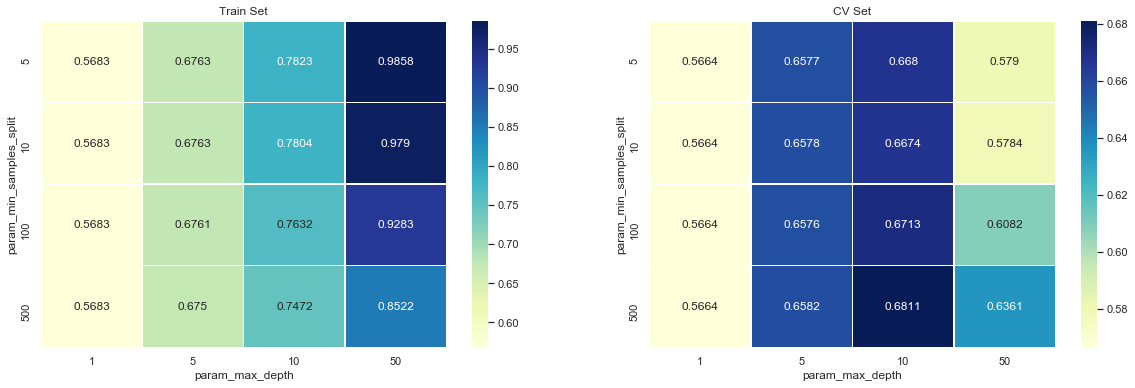

In [94]:
import seaborn as sns; sns.set()
score = pd.DataFrame(set1.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(score.mean_train_score, annot = True,linewidth=.5, cmap="YlGnBu" ,fmt='.4g', ax=ax[0])
sns.heatmap(score.mean_test_score, annot = True, linewidth=.5, cmap="YlGnBu",fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

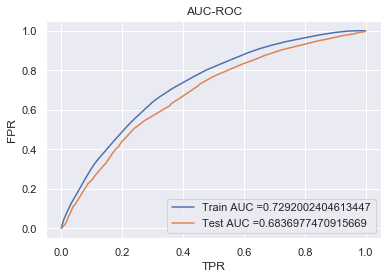

In [97]:
model_dec = DecisionTreeClassifier(max_depth = 10, min_samples_split = 100)
model_dec.fit(X_train_tfidf,y_train)
y_train_pred =  model_dec.predict_proba(X_train_tfidf)[:,1]
y_test_pred =  model_dec.predict_proba(X_test_tfidf)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("AUC-ROC")
plt.show()


AT min_split=500 and max_depth =10 best AUC score on cv data =0.683

Test data confusion matrix


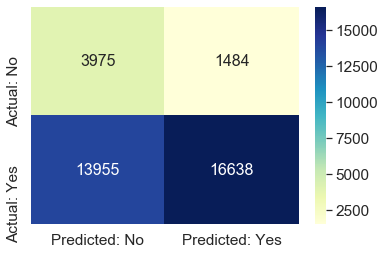

In [120]:
from sklearn.metrics import confusion_matrix
def best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    return t
def predict_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
best_threshold = best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Test data confusion matrix")

confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test, predict_best_t(y_test_pred, best_threshold)), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test, annot=True,annot_kws={"size": 16}, fmt='g',cmap="YlGnBu")
print("="*100)


In [101]:
#false positive data points
FP=[]
price_fp=[]
teacher_number=[]
predictions= predict_best_t(y_test_pred, best_threshold)
for i in range(len(y_test)):
    if(y_test.values[i]==0 and predictions[i]==1):
        FP.append(X_test["essay"].values[i])
        price_fp.append(X_test["price_x"].values[i])
        teacher_number.append(X_test["teacher_number_of_previously_posted_projects"].values[i])



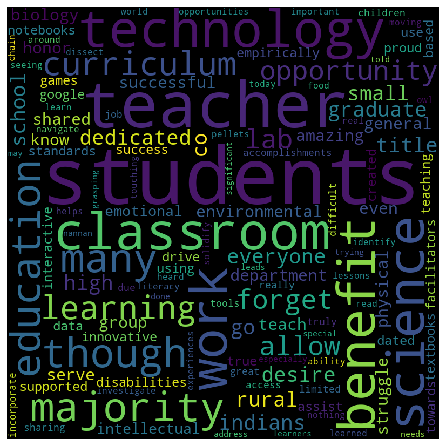

In [102]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in FP:
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords,min_font_size = 10).generate(comment_words)
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

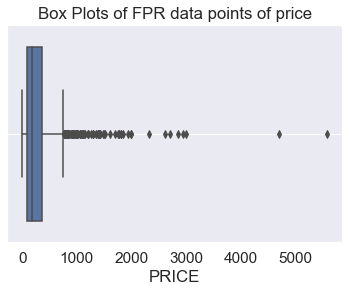

In [103]:
price_fp=pd.DataFrame(price_fp)
price=price_fp.values
sns.boxplot([price])
plt.title('Box Plots of FPR data points of price')
plt.xlabel("PRICE")
plt.grid()
plt.show()


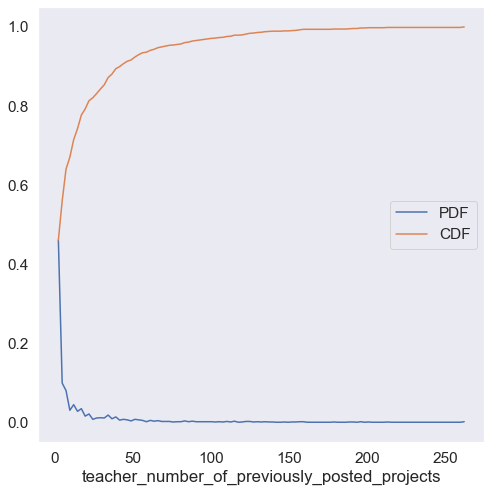

In [104]:
plt.figure(figsize=(8,8))
counts, bin_edges = np.histogram(teacher_number,
bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.grid()
plt.show()

SET 2 :

In [105]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())


In [107]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model_2 = TfidfVectorizer()
tfidf_model_2.fit(X_train["essay"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model_2.get_feature_names(), list(tfidf_model_2.idf_)))
tfidf_words = set(tfidf_model_2.get_feature_names())

In [108]:
# average Word2Vec
# compute average word2vec for each review.
def wvv_tfidf(preprocessed_essay):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in (preprocessed_essay): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors


In [109]:
train_w2v_tfidf_essay=wvv_tfidf(X_train["essay"].values)
test_w2v_tfidf_essay=wvv_tfidf(X_test["essay"].values)


In [110]:
print(len(train_w2v_tfidf_essay))
print(len(test_w2v_tfidf_essay))


73196
36052


In [112]:
#FOR SET 2
from scipy.sparse import hstack# merging all features
X_train_tfidf_w2v= hstack((categories_train,sub_train,X_train_state_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_teacher_number ,X_train_price, X_train_word_count,train_w2v_tfidf_essay,neg_train,neu_train,pos_train,compound_train,X_train_digit,X_train_q)).tocsr()
X_test_tfidf_w2v =hstack((categories_test,sub_test,X_test_state_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_teacher_number ,X_test_price, X_test_word_count ,test_w2v_tfidf_essay,neg_test,neu_test,pos_test,compound_test,X_test_digit,X_test_q)).tocsr()


In [114]:
dec = DecisionTreeClassifier()
set2 = GridSearchCV(dec,parameters,cv=3,scoring = 'roc_auc',n_jobs=-1,return_train_score=True)
set2.fit(X_train_tfidf_w2v,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         '

In [115]:
print('Best score: ',set2.best_score_)
print('best param : ',set2.best_params_)
print('*'*50)

print('*'*50)
print('CV AUC scores')
print(set2.cv_results_['mean_test_score'])
print('Train AUC scores')
print(set2.cv_results_['mean_train_score'])

Best score:  0.660279974996545
best param :  {'max_depth': 5, 'min_samples_split': 500}
**************************************************
**************************************************
CV AUC scores
[0.56865375 0.56865375 0.56865375 0.56865375 0.66020575 0.66018653
 0.66013043 0.66027997 0.63905877 0.64034099 0.64931882 0.65709476
 0.53927784 0.54511737 0.59384397 0.64058056]
Train AUC scores
[0.57008358 0.57008358 0.57008358 0.57008358 0.68678141 0.68678141
 0.68671769 0.68651682 0.78686501 0.7852259  0.76740783 0.74427439
 0.99939554 0.99607868 0.92514743 0.80086728]


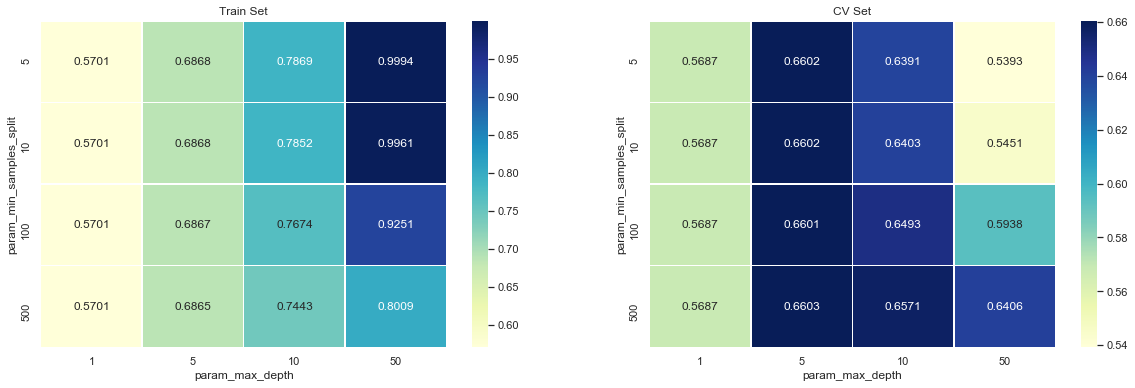

In [116]:
import seaborn as sns; sns.set()
score = pd.DataFrame(set2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(score.mean_train_score, annot = True,linewidth=.5, cmap="YlGnBu" ,fmt='.4g', ax=ax[0])
sns.heatmap(score.mean_test_score, annot = True, linewidth=.5, cmap="YlGnBu",fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

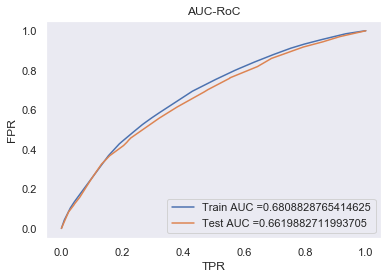

In [118]:
model_dec_2 = DecisionTreeClassifier(max_depth = 5, min_samples_split = 500)
model_dec_2.fit(X_train_tfidf_w2v,y_train)
y_train_pred2 =  model_dec_2.predict_proba(X_train_tfidf_w2v)[:,1]
y_test_pred2 =  model_dec_2.predict_proba(X_test_tfidf_w2v)[:,1]
train_fpr2, train_tpr2, tr_thresholds2 = roc_curve(y_train, y_train_pred2)
test_fpr2, test_tpr2, te_thresholds2 = roc_curve(y_test, y_test_pred2)
plt.plot(train_fpr2, train_tpr2, label="Train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="Test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.grid()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("AUC-RoC")
plt.show()

Test data confusion matrix


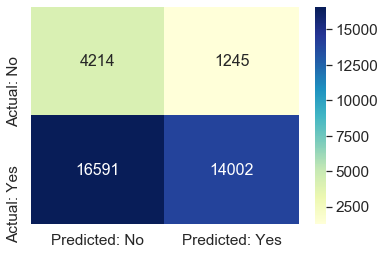

In [123]:
def best_t(t, fpr, tpr):
    t = t[np.argmax(tpr*(1-fpr))]
    return t
best_t=best_t(tr_thresholds2, train_fpr2, train_tpr2)
def predict_best(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
print("Test data confusion matrix")

confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test, predict_best(y_test_pred2, best_t)),['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test, annot=True,annot_kws={"size": 16}, fmt='g',cmap="YlGnBu")
print("="*100)

In [124]:
#false positive data points
FP2=[]
price_fp2=[]
teacher_number2=[]
predictions= predict_best_t(y_test_pred2, best_t)
for i in range(len(y_test)):
    if(y_test.values[i]==0 and predictions[i]==1):
        FP2.append(X_test["essay"].values[i])
        price_fp2.append(X_test["price_x"].values[i])
        teacher_number2.append(X_test["teacher_number_of_previously_posted_projects"].values[i])


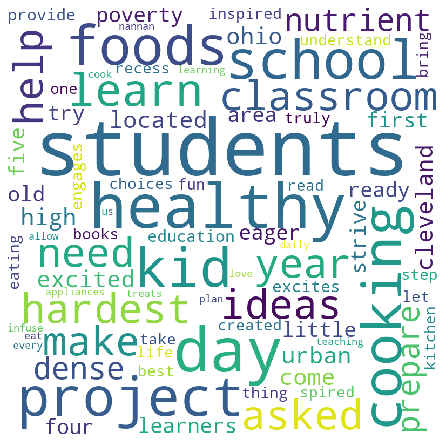

In [125]:
from wordcloud import WordCloud,STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in FP2:
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

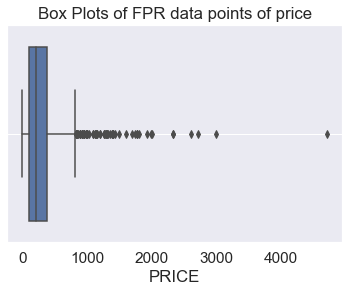

In [126]:
price_fp2=pd.DataFrame(price_fp2)
price=price_fp2.values
sns.boxplot([price])
plt.title('Box Plots of FPR data points of price')
plt.xlabel("PRICE")
plt.grid()
plt.show()


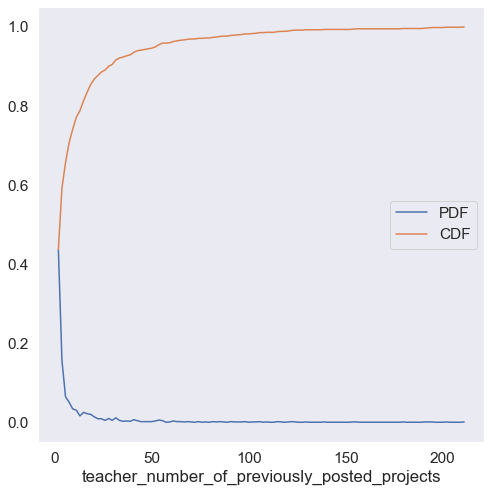

In [127]:
plt.figure(figsize=(8,8))
counts, bin_edges = np.histogram(teacher_number2,
bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.grid()
plt.show()

In [ ]:
TASK:2
    

In [128]:
dt=DecisionTreeClassifier()
dt.fit(X_train_tfidf, y_train)
dt.feature_importances_

array([0.00021218, 0.00017931, 0.00032514, ..., 0.        , 0.00035445,
       0.01970015])

In [129]:
x=dt.feature_importances_<0.001
features=[]
for i in range(len(x)):

    if(bool(x[i])):
        continue
    else:
        features.append(i)
(features)[:20]  

[96,
 99,
 100,
 101,
 366,
 396,
 414,
 763,
 788,
 1044,
 1313,
 1500,
 1543,
 1710,
 2270,
 2379,
 2420,
 2477,
 2491,
 2653]

In [131]:
X_train_1=X_train_tfidf[:,features]
X_test_1=X_test_tfidf[:,features]

In [136]:
dec_3=DecisionTreeClassifier()
task3 = GridSearchCV(dec_3,parameters,cv=3,scoring = 'roc_auc',n_jobs=-1,return_train_score=True, verbose=10)
task3.fit(X_train_1,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:   35.6s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:   38.3s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   51.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   51.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         '

In [137]:
#best params by grid search cv max_depth=10 and min_samples_split=500
print('Best score: ',task3.best_score_)
print('best param : ',task3.best_params_)
print('*'*50)
max_depth= [1, 5, 10, 50]
min_samples_split= [5, 10,100,500]
print('*'*50)
print('CV AUC scores')
print(task3.cv_results_['mean_test_score'])
print('Train AUC scores')
print(task3.cv_results_['mean_train_score'])

Best score:  0.6758521174776716
best param :  {'max_depth': 10, 'min_samples_split': 500}
**************************************************
**************************************************
CV AUC scores
[0.56865375 0.56865375 0.56865375 0.56865375 0.66476024 0.66476564
 0.66474284 0.66471118 0.66826474 0.66921087 0.67240638 0.67585212
 0.54757407 0.55558366 0.61346609 0.65628618]
Train AUC scores
[0.57008358 0.57008358 0.57008358 0.57008358 0.68207435 0.68201591
 0.68188972 0.68188593 0.75338614 0.75186842 0.74180963 0.73299544
 0.99855694 0.9915895  0.91888771 0.82180798]


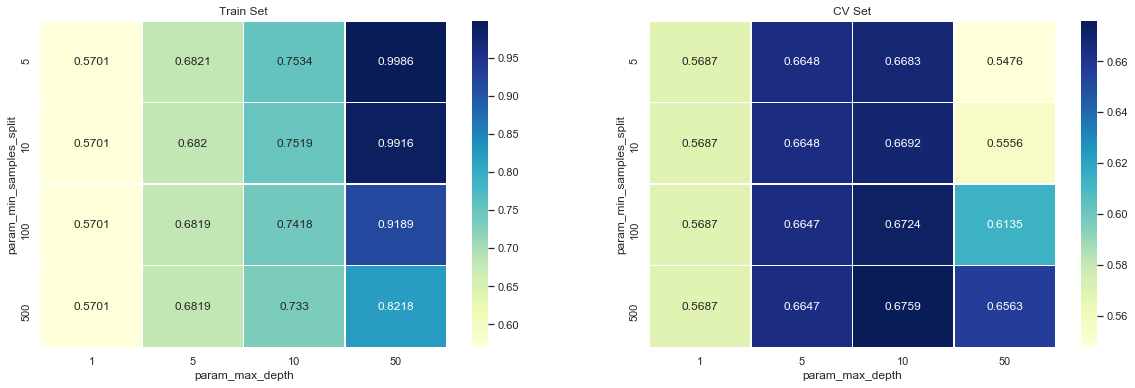

In [138]:
import seaborn as sns; sns.set()
score = pd.DataFrame(task3.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(score.mean_train_score, annot = True,linewidth=.5, cmap="YlGnBu" ,fmt='.4g', ax=ax[0])
sns.heatmap(score.mean_test_score, annot = True, linewidth=.5, cmap="YlGnBu",fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

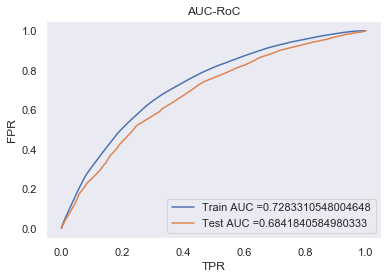

In [139]:
model_dec_3 = DecisionTreeClassifier(max_depth = 10, min_samples_split = 500)
model_dec_3.fit(X_train_1,y_train)
y_train_pred3 =  model_dec_3.predict_proba(X_train_1)[:,1]
y_test_pred3 =  model_dec_3.predict_proba(X_test_1)[:,1]
train_fpr3, train_tpr3, tr_thresholds3 = roc_curve(y_train, y_train_pred3)
test_fpr3, test_tpr3, te_thresholds3 = roc_curve(y_test, y_test_pred3)
plt.plot(train_fpr3, train_tpr3, label="Train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="Test AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.grid()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("AUC-RoC")
plt.show()

Test data confusion matrix


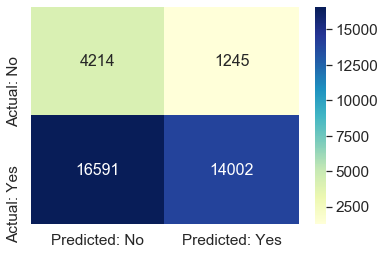

In [141]:
def best_t3(t, fpr, tpr):
    t = t[np.argmax(tpr*(1-fpr))]
    return t
best_t3=best_t3(tr_thresholds2, train_fpr2, train_tpr2)
def predict_best3(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions
print("Test data confusion matrix")

confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test, predict_best3(y_test_pred2, best_t3)),['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix_test, annot=True,annot_kws={"size": 16}, fmt='g',cmap="YlGnBu")
print("="*100)

In [143]:
#false positive data points
FP3=[]
price_fp3=[]
teacher_number3=[]
predictions= predict_best3(y_test_pred3, best_t3)
for i in range(len(y_test)):
    if(y_test.values[i]==0 and predictions[i]==1):
        FP3.append(X_test["essay"].values[i])
        price_fp3.append(X_test["price_x"].values[i])
        teacher_number3.append(X_test["teacher_number_of_previously_posted_projects"].values[i])


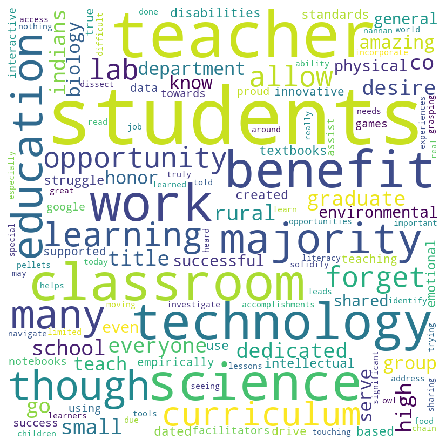

In [144]:
from wordcloud import WordCloud,STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for val in FP3:
    val = str(val)
    tokens = val.split()
for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
for words in tokens :
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords,min_font_size = 10).generate(comment_words)
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

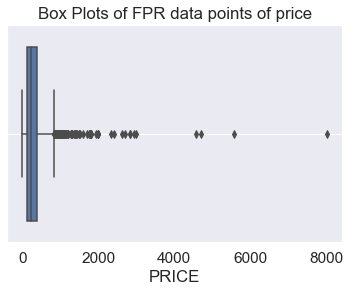

In [145]:
price_fp_3=pd.DataFrame(price_fp3)
price=price_fp_3.values
sns.boxplot([price])
plt.title('Box Plots of FPR data points of price')
plt.xlabel("PRICE")
plt.grid()
plt.show()

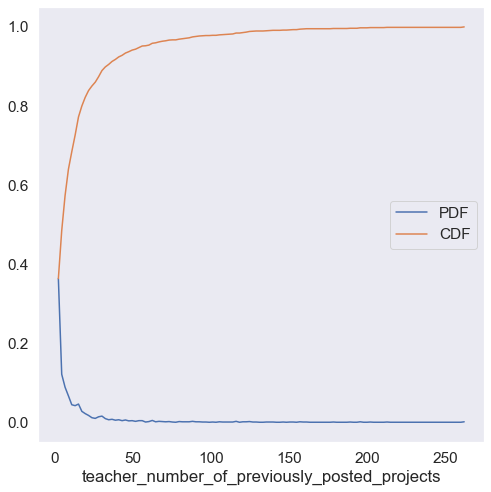

In [146]:
plt.figure(figsize=(8,8))
counts, bin_edges = np.histogram(teacher_number3,
bins='auto', density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
pdfP, = plt.plot(bin_edges[1:], pdf)
cdfP, = plt.plot(bin_edges[1:], cdf)
plt.legend([pdfP, cdfP], ["PDF", "CDF"])
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.grid()
plt.show()

In [158]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer Used", "Model ", "(min samples split,max_depth)", "Test AUC"]
x.add_row(["TFIDF", "Decision Trees", "(500,10)",  0.683])
x.add_row(["TFIDF W2V", "Decision Trees", "(500,5)",  0.661])
x.add_row(["TFIDF-w2v Best Features", "Decision Trees", "(500,10)", 0.684])
print(x)

+-------------------------+----------------+-------------------------------+----------+
|     Vectorizer Used     |     Model      | (min samples split,max_depth) | Test AUC |
+-------------------------+----------------+-------------------------------+----------+
|          TFIDF          | Decision Trees |            (500,10)           |  0.683   |
|        TFIDF W2V        | Decision Trees |            (500,5)            |  0.661   |
| TFIDF-w2v Best Features | Decision Trees |            (500,10)           |  0.684   |
+-------------------------+----------------+-------------------------------+----------+
